# Importing libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Ensure TensorFlow uses GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print("using GPU")
else:
    print("GPU not available, using CPU instead.")

using GPU


# Load and preprocess data along with data Augumentation

In [2]:
data_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN'
classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.


# Load the pre-trained ResNet50 model

In [3]:
pretrained_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers of the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add global average pooling and classification layers  
x = GlobalAveragePooling2D()(pretrained_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

# Create the modified ResNet50 model
model_resnet = Model(inputs=pretrained_model.input, outputs=predictions)

# Compile the model
model_resnet.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Train the model
history_resnet = model_resnet.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1,
    callbacks=[EarlyStopping(patience=9)]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
  2/249 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.1328 - loss: 1.6368   

I0000 00:00:1713736306.396717      98 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713736306.449670      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - accuracy: 0.2536 - loss: 1.5710

W0000 00:00:1713736431.680526      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


249/249 ━━━━━━━━━━━━━━━━━━━━ 177s 635ms/step - accuracy: 0.2536 - loss: 1.5706 - val_accuracy: 0.2494 - val_loss: 1.5567
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 110s 432ms/step - accuracy: 0.2754 - loss: 1.4322 - val_accuracy: 0.2494 - val_loss: 2.4532
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 109s 429ms/step - accuracy: 0.2910 - loss: 1.3996 - val_accuracy: 0.2821 - val_loss: 2.4105
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 117s 457ms/step - accuracy: 0.3032 - loss: 1.3850 - val_accuracy: 0.2494 - val_loss: 2.5815
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 109s 427ms/step - accuracy: 0.3097 - loss: 1.3765 - val_accuracy: 0.2881 - val_loss: 1.4363
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 143s 434ms/step - accuracy: 0.3251 - loss: 1.3578 - val_accuracy: 0.2489 - val_loss: 2.4162
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 109s 428ms/step - accuracy: 0.3281 - loss: 1.3536 - val_accuracy: 0.2725 - val_loss: 2.0870
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 111s 434ms/step - accuracy: 0.3147 - loss: 1.36

# Load the pre-trained VGG19 model

In [4]:
pretrained_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))  # Change input shape

# Freeze all layers of the pre-trained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add global average pooling and classification layers
x = GlobalAveragePooling2D()(pretrained_model.output)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(4, activation='softmax')(x)

# Create the modified VGG19 model
model_vgg = Model(inputs=pretrained_model.input, outputs=predictions)

# Compile the model
model_vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history_vgg = model_vgg.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    verbose=1,
    callbacks=[EarlyStopping(patience=9)]
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10


2024-04-21 22:11:37.370557: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-04-21 22:11:37.370623: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-04-21 22:11:37.370639: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-04-21 22:11:37.370650: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-04-21 22:11:37.370661: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-04-21 22:11:37.370671: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-04-21 22:11:37.370683: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-04-21 22:11:37.370693: E external/local_xla/xla/se

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.4244 - loss: 1.3379

2024-04-21 22:13:41.263671: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.09291, expected 2.38321
2024-04-21 22:13:41.263737: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.88251, expected 5.1728
2024-04-21 22:13:41.263748: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 5.48389, expected 4.77418
2024-04-21 22:13:41.263757: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 5.23066, expected 4.52095
2024-04-21 22:13:41.263766: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 5.78972, expected 5.08001
2024-04-21 22:13:41.263790: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.97856, expected 4.26885
2024-04-21 22:13:41.263799: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 4.36704, expected 3.65734
2024-04-21 22:13:41.263823: 

249/249 ━━━━━━━━━━━━━━━━━━━━ 134s 449ms/step - accuracy: 0.4246 - loss: 1.3373 - val_accuracy: 0.4163 - val_loss: 1471.7659
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 111s 435ms/step - accuracy: 0.5546 - loss: 1.0374 - val_accuracy: 0.4741 - val_loss: 4323.9521
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 109s 426ms/step - accuracy: 0.5991 - loss: 0.9464 - val_accuracy: 0.6008 - val_loss: 1152.4569
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 108s 425ms/step - accuracy: 0.6212 - loss: 0.8987 - val_accuracy: 0.3499 - val_loss: 1177.7109
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 109s 428ms/step - accuracy: 0.6431 - loss: 0.8693 - val_accuracy: 0.5988 - val_loss: 1242.7617
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 108s 425ms/step - accuracy: 0.6315 - loss: 0.8712 - val_accuracy: 0.6159 - val_loss: 1620.3035
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 108s 426ms/step - accuracy: 0.6334 - loss: 0.8572 - val_accuracy: 0.5279 - val_loss: 2384.9646
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 109s 430ms/step - accuracy

# Custom CNN model

In [9]:
def create_custom_model(lr=0.001, dropout_rate=0.5, l2_reg=0.001):
    model = Sequential([
        Conv2D(filters=128, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),

        Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3)),

        Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),

        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),

        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),

        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding="same", kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),

        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(1024, activation='relu', kernel_regularizer=l2(l2_reg)),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])

    model.compile(
        loss='categorical_crossentropy',
        optimizer=SGD(learning_rate=lr),
        metrics=['accuracy']
    )

    return model

# Hyperparameter tuning

In [18]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print(len(gpus), "Physical GPU")
    except RuntimeError as e:
        print(e)
param_grid = {
    'lr': [0.001, 0.01],
    'dropout_rate': [0.3, 0.5],
    'l2_reg': [0.001, 0.01]
}

best_acc = 0
best_params = None
best_history = None

for lr in param_grid['lr']:
    for dropout_rate in param_grid['dropout_rate']:
        for l2_reg in param_grid['l2_reg']:
            model = create_custom_model(lr=lr, dropout_rate=dropout_rate, l2_reg=l2_reg)
            history = model.fit(train_generator, epochs=10, validation_data=val_generator, verbose=0)
            val_acc = max(history.history['val_accuracy'])
            
            if val_acc > best_acc:
                best_acc = val_acc
                best_params = {'lr': lr, 'dropout_rate': dropout_rate, 'l2_reg': l2_reg}
                best_history = history
                best_model = model

print("Best Validation Accuracy: %f using %s" % (best_acc, best_params))

# Print accuracy and loss for the best set of hyperparameters
for epoch in range(10):
    print(f"Epoch {epoch+1}/{10}")
    print(f"Train Loss: {history.history['loss'][epoch]:.4f} - Train Accuracy: {history.history['accuracy'][epoch]:.4f}")
    print(f"Validation Loss: {history.history['val_loss'][epoch]:.4f} - Validation Accuracy: {history.history['val_accuracy'][epoch]:.4f}")

1 Physical GPU


W0000 00:00:1713742015.131500      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713742106.787482      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713743171.412274      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713743257.410721      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713744266.253606      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713744352.301690      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713745368.070187      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713745454.058958      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Best Validation Accuracy: 0.844646 using {'lr': 0.01, 'dropout_rate': 0.5, 'l2_reg': 0.001}
Epoch 1/10
Train Loss: 54.4660 - Train Accuracy: 0.3426
Validation Loss: 51.8645 - Validation Accuracy: 0.2589
Epoch 2/10
Train Loss: 48.9991 - Train Accuracy: 0.4961
Validation Loss: 48.4834 - Validation Accuracy: 0.2634
Epoch 3/10
Train Loss: 44.1383 - Train Accuracy: 0.6841
Validation Loss: 48.5091 - Validation Accuracy: 0.3283
Epoch 4/10
Train Loss: 39.7996 - Train Accuracy: 0.8055
Validation Loss: 47.6998 - Validation Accuracy: 0.2509
Epoch 5/10
Train Loss: 35.9610 - Train Accuracy: 0.8609
Validation Loss: 55.8759 - Validation Accuracy: 0.2509
Epoch 6/10
Train Loss: 32.5193 - Train Accuracy: 0.8966
Validation Loss: 31.7033 - Validation Accuracy: 0.6521
Epoch 7/10
Train Loss: 29.4305 - Train Accuracy: 0.9203
Validation Loss: 29.2028 - Validation Accuracy: 0.6606
Epoch 8/10
Train Loss: 26.6491 - Train Accuracy: 0.9325
Validation Loss: 70.5070 - Validation Accuracy: 0.2489
Epoch 9/10
Train Los

## Model Accuracy and losses comaprision.

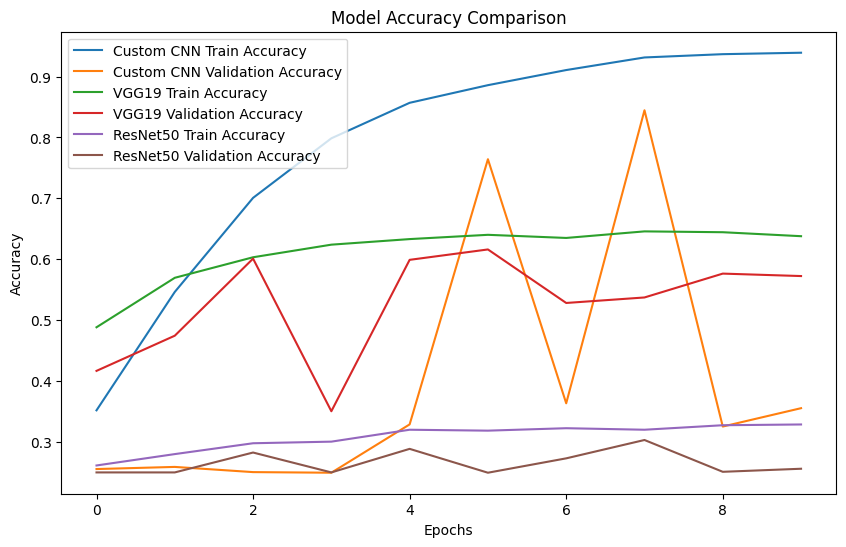

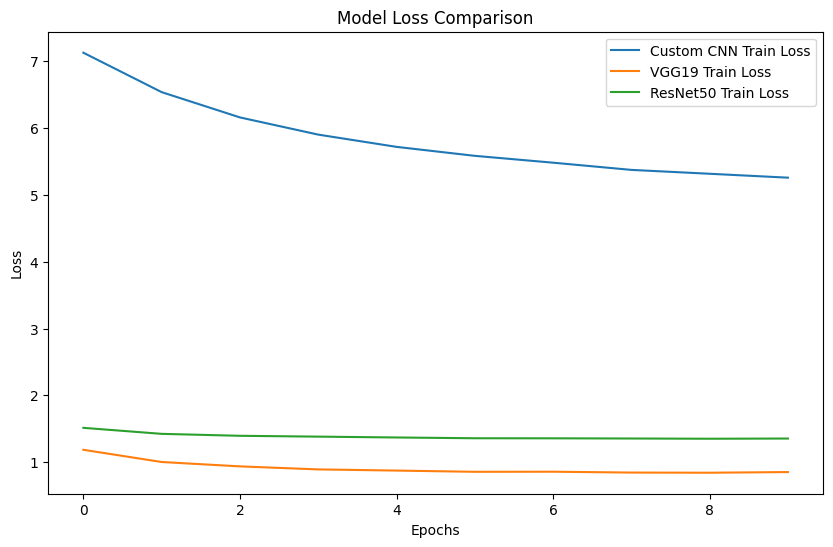

In [19]:
# Accuracy vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(best_history.history['accuracy'], label='Custom CNN Train Accuracy')
plt.plot(best_history.history['val_accuracy'], label='Custom CNN Validation Accuracy')
plt.plot(history_vgg.history['accuracy'], label='VGG19 Train Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='VGG19 Validation Accuracy')
plt.plot(history_resnet.history['accuracy'], label='ResNet50 Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='ResNet50 Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.legend()
plt.show()

# Loss vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(best_history.history['loss'], label='Custom CNN Train Loss')
plt.plot(history_vgg.history['loss'], label='VGG19 Train Loss')
plt.plot(history_resnet.history['loss'], label='ResNet50 Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Comparison')
plt.legend()
plt.show()

## Testing the model accuracy on Unseen data and plotting the accuracy of classification

Found 2487 images belonging to 4 classes.
ResNet50 Test Accuracy: 0.25452351570129395
VGG19 Test Accuracy: 0.5464414954185486
Custom CNN Test Accuracy: 0.9306594371795655


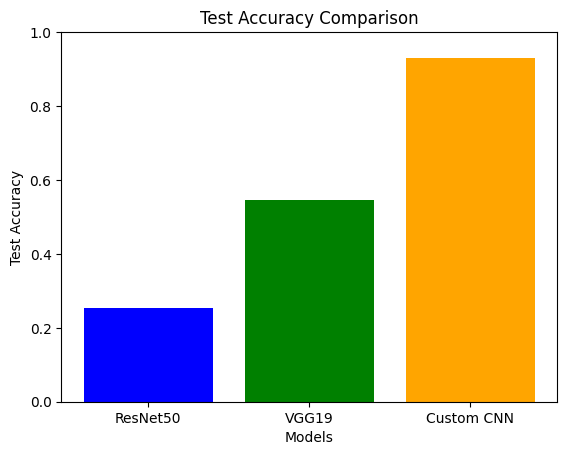

"test_generator = test_datagen.flow_from_directory(\n    test_data_dir,\n    target_size=(224, 224),\n    batch_size=32,\n    class_mode='categorical',\n    shuffle=False  # Ensure the order of predictions matches the order of actual labels\n)"

In [32]:
# # Load the test dataset
test_data_dir = '/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST'

# # Data augmentation
test_datagen = ImageDataGenerator(
     rescale=1./255,
     rotation_range=20,
     width_shift_range=0.1,
     height_shift_range=0.1,
     shear_range=0.1,
     zoom_range=0.2,
     horizontal_flip = True,
    validation_split=0.2)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True  # Ensure the order of predictions matches the order of actual labels
)

# Evaluate test dataset accuracy
resnet50_test_accuracy = model_resnet.evaluate(test_generator, verbose=0)[1]
print(f'ResNet50 Test Accuracy: {resnet50_test_accuracy}')

vgg19_test_accuracy = model_vgg.evaluate(test_generator, verbose=0)[1]
print(f'VGG19 Test Accuracy: {vgg19_test_accuracy}')

custom_cnn_test_accuracy = model.evaluate(test_generator, verbose=0)[1]

print(f'Custom CNN Test Accuracy: {custom_cnn_test_accuracy}')

# Test accuracies
test_accuracies = [resnet50_test_accuracy, vgg19_test_accuracy, custom_cnn_test_accuracy]
models = ['ResNet50', 'VGG19', 'Custom CNN']

# Plotting
plt.bar(models, test_accuracies, color=['blue', 'green', 'orange'])
plt.xlabel('Models')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy Comparison')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1
plt.show()

